In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Carrega a base de dados a partir de seu caminho
data = np.load('dataset.npz', allow_pickle=True)
X = data['X_train']
y = data['y_train']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Scale
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [4]:
#Model
initializer = keras.initializers.GlorotNormal(seed=12227)

inputs = keras.layers.Input(shape=(X_test_sc.shape[1],))

n = 128
H = keras.layers.Dense(units=n, activation='relu', kernel_initializer=initializer)(inputs)
shortcut = H
H = keras.layers.Dense(units=n*2, activation='relu', kernel_initializer=initializer)(H)
H = keras.layers.Dense(units=n*4, activation='relu', kernel_initializer=initializer)(H)
H = keras.layers.Dense(units=n*8, activation='relu', kernel_initializer=initializer)(H)
H = keras.layers.Dense(units=n*4, activation='relu', kernel_initializer=initializer)(H)
H = keras.layers.Dense(units=n*2, activation='relu', kernel_initializer=initializer)(H)
H = keras.layers.Dense(units=n, activation='relu', kernel_initializer=initializer)(H)
H=H+shortcut
outputs = keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer=initializer)(H)

model = keras.models.Model(inputs=inputs, outputs=outputs)

2024-08-19 00:11:52.996415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 00:11:52.999477: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [6]:
def lr_schedule(epoch, lr):
    if epoch < 10:
        return 0.01
    elif epoch < 20:
        return 0.001
    elif epoch < 30:
        return 0.0001
    else:
        return 0.0001/epoch
    
scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
    
history = model.fit(X_train_sc, y_train, epochs=50, batch_size=256, callbacks=[scheduler])

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - binary_accuracy: 0.7504 - loss: 0.6571 - learning_rate: 0.0100
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - binary_accuracy: 0.8081 - loss: 0.4082 - learning_rate: 0.0100
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - binary_accuracy: 0.8113 - loss: 0.4021 - learning_rate: 0.0100
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - binary_accuracy: 0.8102 - loss: 0.3995 - learning_rate: 0.0100
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - binary_accuracy: 0.8141 - loss: 0.3969 - learning_rate: 0.0100
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - binary_accuracy: 0.8101 - loss: 0.3966 - learning_rate: 0.0100
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.8169 - loss: 0.3926 - learning_rate: 0.0100
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - binary_accuracy: 0.8162 - loss: 0.3920 - learning_rate: 0.0100
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - b

299/299 ━━━━━━━━━━━━━━━━━━━━ -1s -2487us/step


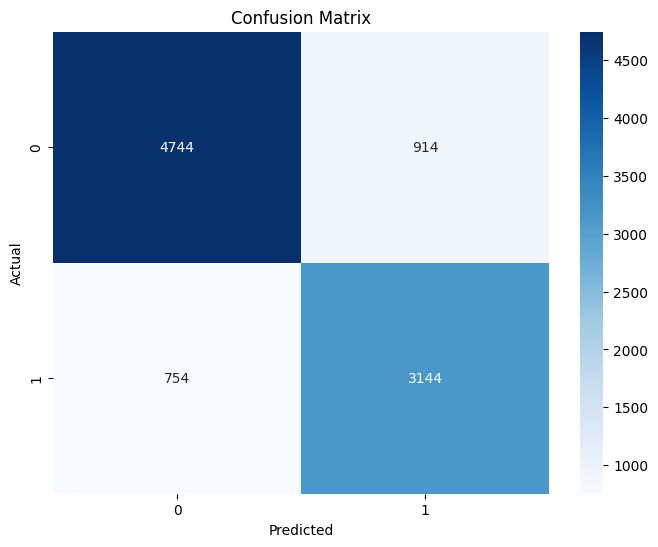

In [12]:
# Make predictions on the test set

y_pred = model.predict(X_test_sc)
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Evaluate the model on the test set
tn, fp, fn, tp = cm.ravel()
loss, accuracy = model.evaluate(X_test_sc, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calcule a sensibilidade (Recall ou TPR)
sensibilidade = tp / (tp + fn)
print(f"Sensibilidade: {sensibilidade:.4f}")

# Calcule a especificidade (TNR)
especificidade = tn / (tn + fp)
print(f"Especificidade: {especificidade:.4f}")

Test Loss: 0.3857
Test Accuracy: 0.8255
Sensibilidade: 0.8066
Especificidade: 0.8385
